# 6He Quantum Krylov Method v5: Gate Counting Included
Applying Quantum Krylov to 6He system.
Includes a `count_gates` helper to inspect circuit complexity.

In [1]:

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.synthesis import SuzukiTrotter

# Primitives
from qiskit.primitives import StatevectorSampler
# Check for BackendSamplerV2 availability
try:
    from qiskit.primitives import BackendSamplerV2
except ImportError:
    from qiskit.primitives import BackendSampler as BackendSamplerV2

# For Noisy Simulation
from qiskit_ibm_runtime.fake_provider import FakeManilaV2 
from qiskit_aer import AerSimulator

# For Real Device
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import SamplerV2 as RuntimeSamplerV2

from sympy.physics.quantum.cg import CG
import os


In [2]:

# --- Hamiltonian Construction ---

def parse_ckpot(filepath):
    spe = {}
    tbme = {}
    
    with open(filepath, 'r') as f:
        lines = f.readlines()
    
    reading_spe = False
    reading_tbme = False
    
    for line in lines:
        parts = line.split()
        if not parts or parts[0].startswith('!'):
            continue
        try:
            nums = [float(x) for x in parts]
        except ValueError:
            continue
            
        if len(nums) == 2 and int(nums[0]) == 4 and int(nums[1]) == 0:
            reading_spe = True
            continue
        if len(nums) == 3 and int(nums[0]) == 34:
            reading_spe = False
            reading_tbme = True
            continue
            
        if reading_spe:
            if len(nums) >= 3:
                idx = int(nums[0])
                energy = nums[2]
                if idx == 3: spe['p1/2'] = energy
                if idx == 4: spe['p3/2'] = energy
                
        if reading_tbme:
            if len(nums) >= 6:
                i, j, k, l = int(nums[0]), int(nums[1]), int(nums[2]), int(nums[3])
                J = int(nums[4])
                val = nums[5]
                tbme[(i,j,k,l,J)] = val
                
    return spe, tbme

# Load interaction
ckpot_path = '../interaction_file/ckpot.snt'
if not os.path.exists(ckpot_path):
    print(f"Warning: {ckpot_path} not found. Using dummy values.")
    spe = {'p1/2': 0.0, 'p3/2': 2.0}
    tbme_data = {}
else:
    spe, tbme_data = parse_ckpot(ckpot_path)

# CG Coefficients
def get_cg(j, m1, m2, J, M):
    return float(CG(j, m1, j, m2, J, M).doit())

c_0_J0 = get_cg(1/2, 1/2, -1/2, 0, 0)
c_1_J0 = get_cg(3/2, 1/2, -1/2, 0, 0)
c_1_J2 = get_cg(3/2, 1/2, -1/2, 2, 0)
c_2_J0 = get_cg(3/2, 3/2, -3/2, 0, 0)
c_2_J2 = get_cg(3/2, 3/2, -3/2, 2, 0)

basis = {
    0: {'shell': 3, 'coeffs': {0: c_0_J0}},
    1: {'shell': 4, 'coeffs': {0: c_1_J0, 2: c_1_J2}},
    2: {'shell': 4, 'coeffs': {0: c_2_J0, 2: c_2_J2}}
}

def get_tbme_val(i, j, k, l, J):
    key = (i, j, k, l, J)
    if key in tbme_data: return tbme_data[key]
    key = (k, l, i, j, J)
    if key in tbme_data: return tbme_data[key]
    return 0.0

V_matrix = np.zeros((3, 3))
for a in range(3):
    for b in range(3):
        shell_a = basis[a]['shell']
        shell_b = basis[b]['shell']
        val = 0.0
        common_Js = set(basis[a]['coeffs'].keys()) & set(basis[b]['coeffs'].keys())
        for J in common_Js:
            c_a = basis[a]['coeffs'][J]
            c_b = basis[b]['coeffs'][J]
            mat_el = get_tbme_val(shell_a, shell_a, shell_b, shell_b, J)
            val += c_a * c_b * mat_el
        V_matrix[a, b] = val

E_pair = np.zeros(3)
epsilon = {3: spe['p1/2'], 4: spe['p3/2']}
for i in range(3):
    shell = basis[i]['shell']
    E_pair[i] = 2 * epsilon[shell] + V_matrix[i, i]

# Construct H_op
ham_ops = []
num_qubits = 3

for i in range(num_qubits):
    label = ['I'] * num_qubits
    label[i] = 'Z'
    z_str = "".join(reversed(label))
    ham_ops.append(("I"*num_qubits, E_pair[i] / 2))
    ham_ops.append((z_str, -E_pair[i] / 2))

for i in range(num_qubits):
    for j in range(i + 1, num_qubits):
        coupling = V_matrix[i, j]
        
        label_x = ['I'] * num_qubits
        label_x[i] = 'X'
        label_x[j] = 'X'
        x_str = "".join(reversed(label_x))
        ham_ops.append((x_str, coupling / 2))
        
        label_y = ['I'] * num_qubits
        label_y[i] = 'Y'
        label_y[j] = 'Y'
        y_str = "".join(reversed(label_y))
        ham_ops.append((y_str, coupling / 2))

H_op = SparsePauliOp.from_list(ham_ops).simplify()
print("Hamiltonian Operator:")
print(H_op)

# Exact Solution
full_matrix = H_op.to_matrix()
indices = [1, 2, 4]
sub_mat = np.zeros((3, 3), dtype=complex)
for r, i in enumerate(indices):
    for c, j in enumerate(indices):
        sub_mat[r, c] = full_matrix[i, j]
exact_evals, _ = np.linalg.eigh(sub_mat)
print(f"Exact Eigenvalues (Physical Subspace): {exact_evals}")


Hamiltonian Operator:
SparsePauliOp(['III', 'IIZ', 'IZI', 'ZII', 'IXX', 'IYY', 'XIX', 'YIY', 'XXI', 'YYI'],
              coeffs=[ 3.927775  +0.j, -2.48      +0.j, -0.7238875 +0.j, -0.7238875 +0.j,
  0.89318193+0.j,  0.89318193+0.j, -0.89318193+0.j, -0.89318193+0.j,
  0.4270625 +0.j,  0.4270625 +0.j])
Exact Eigenvalues (Physical Subspace): [-0.56210369  2.3019      6.11575369]


Ansatz Circuit:


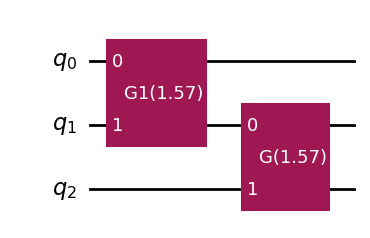

In [3]:

# --- Ansatz Circuit ---

def G1_gate(theta):
    theta = theta * 2
    circ = QuantumCircuit(2)
    circ.x(0)
    circ.ry(theta, 1)
    circ.cx(1, 0)
    circ.name = f'G1({theta:.2f})'
    return circ.to_gate()

def G_gate(theta):
    theta = theta * 2
    circ = QuantumCircuit(2)
    circ.cry(theta, 0, 1)
    circ.cx(1, 0)
    circ.name = f'G({theta:.2f})'
    return circ.to_gate()

def ansatz(params):
    qc = QuantumCircuit(3)
    qc.append(G1_gate(params[0]), [0, 1])
    qc.append(G_gate(params[1]), [1, 2])
    return qc

# Initial Parameters
init_params = [np.pi/4, np.pi/4]
qc_ansatz = ansatz(init_params)
print("Ansatz Circuit:")
qc_ansatz.draw('mpl')


In [4]:

# --- Quantum Krylov Functions ---

def count_gates(qc, name="Circuit"):
    """Helper to print gate counts for a circuit."""
    ops = qc.count_ops()
    depth = qc.depth()
    print(f"[{name}] Depth: {depth}, Gates: {ops}")
    return ops

def make_U(i, delta_t, trotter_steps, hamiltonian_op, target_qubits, Trotter_order=4):
    Ntar = len(target_qubits) 
    time = i * delta_t 
    circuit_U = QuantumCircuit(Ntar)
    expiHt = PauliEvolutionGate(hamiltonian_op, time, synthesis=SuzukiTrotter(order=Trotter_order,reps=trotter_steps))
    circuit_U.append(expiHt, range(Ntar))
    qc_U = circuit_U.decompose().decompose()
    return qc_U

def make_cU(Uprep, Ui, Ntar, only_Uprep=False):
    circuit_cUi = QuantumCircuit(Ntar)
    circuit_cUi.append(Uprep, range(Ntar))
    if not only_Uprep:
        circuit_cUi.append(Ui, range(Ntar))
    circuit_cUi = circuit_cUi.decompose(reps=1)
    return circuit_cUi.to_gate().control(1)

def get_idx_ancilla_in_string(n_qubit, ancilla, Qiskit_ordering=True):
    idx_ancilla = None
    if ancilla != None:
        if Qiskit_ordering:
            idx_ancilla = n_qubit-1 - ancilla
        else:
            idx_ancilla = ancilla
    return idx_ancilla

def make_overlap_qc_1c(Ntar, gate_cprep, gate_Uij, ancilla_qubits, target_qubits, do_measurement=True):
    qc_re = QuantumCircuit(1+Ntar, 1) # Overlap, Re part
    qc_re.h(0) # X basis
    qc_re.append(gate_cprep, ancilla_qubits + target_qubits)
    qc_re.append(gate_Uij, target_qubits)
    qc_re.x(0)
    qc_re.append(gate_cprep, ancilla_qubits + target_qubits)
    qc_re.x(0)
    qc_re.h(0) 
    if do_measurement:
        qc_re.measure(0,0)

    # Overlap, Im part 
    qc_im = QuantumCircuit(1+Ntar,1)
    qc_im.h(0)
    qc_im.append(gate_cprep, ancilla_qubits + target_qubits)
    qc_im.append(gate_Uij, target_qubits)
    qc_im.x(0)
    qc_im.append(gate_cprep, ancilla_qubits + target_qubits)
    qc_im.x(0)
    # Y basis
    qc_im.sdg(0)
    qc_im.h(0)
    if do_measurement:
        qc_im.measure(0,0)

    return qc_re, qc_im

def measure_overlap_1c(num_shot, Ntar, gate_cprep, gate_Uij, ancilla_qubits, target_qubits, sampler, using_statevector, backend_for_transpile=None):
    # If using Statevector, no measurement needed in circuit
    do_meas = not using_statevector
    qc_re, qc_im = make_overlap_qc_1c(Ntar, gate_cprep, gate_Uij, ancilla_qubits, target_qubits, do_meas)
    
    # Transpile first if needed (even for statevector if we want actual gate counts, but usually for SV we don't care as much)
    # However, if backend provided, we check counts post-transpile
    if backend_for_transpile is not None:
         qc_re = transpile(qc_re, backend_for_transpile)
         qc_im = transpile(qc_im, backend_for_transpile)
         # Print gate counts for first overlap calculation to avoid spam
         # Using a global or external flag is better, but here just check if it's new
         pass 

    if using_statevector:
        results = [ Statevector.from_instruction(qc).probabilities_dict() for qc in [qc_re, qc_im]]
        prob_Re = results[0]
        prob_Im = results[1] 
    else:
        # Run with Sampler V2
        pub_re = (qc_re,)
        pub_im = (qc_im,)
        job = sampler.run([pub_re, pub_im], shots=num_shot)
        result = job.result() 
        
        def get_counts_safe(pub_res):
            if hasattr(pub_res.data, 'meas'): 
                return pub_res.data.meas.get_counts()
            elif hasattr(pub_res.data, 'c'): 
                return pub_res.data.c.get_counts()
            else:
                try: return pub_res.data.c.get_counts()
                except: return pub_res.data.meas.get_counts()

        counts_re = get_counts_safe(result[0])
        counts_im = get_counts_safe(result[1])
        
        # Convert counts to probabilities
        total_re = sum(counts_re.values())
        total_im = sum(counts_im.values())
        prob_Re = {k: v/total_re for k,v in counts_re.items()}
        prob_Im = {k: v/total_im for k,v in counts_im.items()}

    total_Re = np.sum(list(prob_Re.values()))
    total_Im = np.sum(list(prob_Im.values()))
    if total_Re == 0 or total_Im == 0:
        return 0.0 + 0.0j

    n_qubit_Re = len(list(prob_Re.keys())[0])
    n_qubit_Im = len(list(prob_Im.keys())[0])
    anc = ancilla_qubits[0] if ancilla_qubits else 0
    idx_ancilla_Re = get_idx_ancilla_in_string(n_qubit_Re, anc, Qiskit_ordering=True)
    idx_ancilla_Im = get_idx_ancilla_in_string(n_qubit_Im, anc, Qiskit_ordering=True)

    p0 = np.sum([ count for bitstr, count in prob_Re.items() if bitstr[idx_ancilla_Re] == '0' ]) 
    p1 = np.sum([ count for bitstr, count in prob_Re.items() if bitstr[idx_ancilla_Re] == '1' ]) 
    ReN = p0 - p1 

    p0 = np.sum([ count for bitstr, count in prob_Im.items() if bitstr[idx_ancilla_Im] == '0' ]) 
    p1 = np.sum([ count for bitstr, count in prob_Im.items() if bitstr[idx_ancilla_Im] == '1' ]) 
    ImN = p0 - p1

    if abs(ImN) < 1e-5: ImN = 0.0

    N_ij = ReN - 1j * ImN
    return N_ij, qc_re # Return QC for gate counting

def compute_N_matrix(it, delta_t, trotter_steps, Ntar, params, hamiltonian_op, num_shot, sampler, ancilla_qubits=[0], target_qubits=[1,2,3], using_statevector=True, backend_for_transpile=None):
    Nmat = np.zeros((it, it), dtype=complex)
    Uprep = ansatz(params)
    gate_cprep = make_cU(Uprep, None, Ntar, only_Uprep=True)
    qc_cache = {}

    def get_qc_U(k):
        if k not in qc_cache:
            qc_u = make_U(k, delta_t, trotter_steps, hamiltonian_op, range(Ntar))
            qc_cache[k] = qc_u
        return qc_cache[k]

    for ii, i in enumerate(range(it)):
        for jj, j in enumerate(range(ii + 1)):
            qc_Uij = get_qc_U(i - j)
            Nij, qc_used = measure_overlap_1c(num_shot, Ntar, gate_cprep, qc_Uij, ancilla_qubits, target_qubits, sampler, using_statevector, backend_for_transpile)
            Nmat[ii, jj] = Nij
            if ii != jj:
                Nmat[jj, ii] = np.conj(Nij)
                
            # Log gates for diagonal element (ii==jj) == N(0) check or first element
            if ii==0 and jj==0 and i==0:
                 print(f"  [Gate Count Sample] Overlap Circuit (N_00):")
                 count_gates(qc_used, "Re(N_00)")
                 
    return Nmat

def expec_Zstring_from_counts(counts, idx_relevant, Qiskit_ordering=True, target_qubits=[], ancilla_qubit=None):
    exp_val = exp_val_p0 = exp_val_p1 = 0.0
    n_shot = sum(counts.values())
    
    if n_shot == 0: return 0.0, 0.0, 0.0

    sample_key = list(counts.keys())[0]
    n_qubit = len(sample_key)
    idx_ancilla = get_idx_ancilla_in_string(n_qubit, ancilla_qubit, Qiskit_ordering)
    
    for bitstr, count in counts.items():
        if ancilla_qubit != None and target_qubits != []:
            bitstr_target = ''.join([bitstr[k] for k in range(n_qubit) if k != idx_ancilla])
        else:
            bitstr_target = bitstr
        tmp = 1.0
        for idx in idx_relevant:
            if Qiskit_ordering:
                idx = -1 - idx
            try:
                bit = int(bitstr_target[idx])
            except IndexError:
                bit = 0 
            tmp *= (1 - 2 * bit)
        exp_val += tmp * count
        
        if ancilla_qubit != None:
            try:
                anc_bit = int(bitstr[idx_ancilla])
            except IndexError:
                anc_bit = 0
            if anc_bit == 0:
                exp_val_p0 += tmp * count
            else:
                exp_val_p1 += tmp * count
                
    exp_val /= n_shot; exp_val_p0 /= n_shot; exp_val_p1 /= n_shot
    return exp_val, exp_val_p0, exp_val_p1

def get_idx_to_measure(pauli_str, Qiskit_order=True):
    idxs = [ idx for idx, p in enumerate(pauli_str) if p != "I"]
    if Qiskit_order:
        idxs = [ len(pauli_str) - 1 - idx for idx in idxs]
    return idxs

def get_idx_circuit(op_string, term_types):
    idx_circuit = None
    if set(op_string) == {'I', 'Z'} or set(op_string) == {'I'}:                            
        for i in range(len(term_types)):
            if set(term_types[i]) == {'I', 'Z'} or set(term_types[i]) == {'I'}:
                idx_circuit = i
                break
    elif set(op_string) == {'X', 'I'} or set(op_string) == {'X'}:
        for i in range(len(term_types)):
            if set(term_types[i]) == {'X', 'I'} or set(term_types[i]) == {'X'}:
                idx_circuit = i
                break
    elif set(op_string) == {'Y', 'I'} or set(op_string) == {'Y'}:
        for i in range(len(term_types)):
            if set(term_types[i]) == {'Y', 'I'} or set(term_types[i]) == {'Y'}:
                idx_circuit = i
                break
    return idx_circuit

def make_Circ_forNondiagH(it, term_types, Ntar, ancilla_qubits, target_qubits, cPrep, U_kj, qcs_re, qcs_im, using_statevector):
    if abs(it) > 0:
        for idx_term in range(len(term_types)):
            term = term_types[idx_term]
            qc = QuantumCircuit(1+Ntar)
            qc.h(0)
            qc.append(cPrep, range(Ntar+1))
            qc.append(U_kj,  target_qubits)
            qc.x(0)
            qc.append(cPrep, range(Ntar+1))
            qc.x(0)
            qc.h(0)
            
            qc_im = QuantumCircuit(1+Ntar)
            qc_im.h(0)
            qc_im.append(cPrep, range(Ntar+1))
            qc_im.append(U_kj,  target_qubits)
            qc_im.x(0)
            qc_im.append(cPrep, range(Ntar+1))
            qc_im.x(0)
            qc_im.sdg(0)
            qc_im.h(0)
            
            if term == "IZ": pass
            elif term == "XX":
                qc.h(target_qubits)
                qc_im.h(target_qubits)
            elif term == "YY":
                qc.sdg(target_qubits)
                qc.h(target_qubits)
                qc_im.sdg(target_qubits)
                qc_im.h(target_qubits)
                
            if not using_statevector:
                 qc.measure_all()
                 qc_im.measure_all()

            qcs_re.append(qc)
            qcs_im.append(qc_im)

def compute_H_matrix(it, delta_t, trotter_steps, Ntar, params, hamiltonian_op, term_types, num_shots, sampler, ancilla_qubits=[0], target_qubits=[1,2,3], using_statevector=True, backend_for_transpile=None):
    Hmat = np.zeros((it, it), dtype=complex)
    Uprep = ansatz(params)
    
    qc_cache = {}
    def get_qc_U(k):
        if k not in qc_cache:
            qc_u = make_U(k, delta_t, trotter_steps, hamiltonian_op, range(Ntar))
            qc_cache[k] = qc_u
        return qc_cache[k]

    # Helper to safe read counts from SamplerV2 result
    def get_counts_safe(pub_res):
        if hasattr(pub_res.data, 'meas'): 
            return pub_res.data.meas.get_counts()
        elif hasattr(pub_res.data, 'c'): 
            return pub_res.data.c.get_counts()
        else:
            try: return pub_res.data.c.get_counts()
            except: return pub_res.data.meas.get_counts()

    for k in range(it):
        Ui = get_qc_U(k)
        
        qcs_diag = [] 
        for idx_term in range(len(term_types)):
            term = term_types[idx_term]
            qc = QuantumCircuit(Ntar)
            qc.append(Uprep, range(Ntar))
            qc.append(Ui, range(Ntar))
            if term == "IZ": pass
            elif term == "XX": qc.h(range(Ntar))
            elif term == "YY": 
                qc.sdg(range(Ntar))
                qc.h(range(Ntar))
            if not using_statevector:
                qc.measure_all()
            qcs_diag.append(qc)
            
        if using_statevector:
            results = [ Statevector.from_instruction(qc).probabilities_dict() for qc in qcs_diag]
        else:
            pubs = []
            for qc in qcs_diag:
                if backend_for_transpile:
                    qc = transpile(qc, backend_for_transpile)
                pubs.append((qc,))
            job = sampler.run(pubs, shots=num_shots)
            res = job.result()
            results = [ get_counts_safe(r) for r in res ]
        
        H_sum = 0.0
        for idx_H in range(len(hamiltonian_op.paulis)):
            op_string = hamiltonian_op.paulis[idx_H].to_label()
            idx_relevant = get_idx_to_measure(op_string)
            idx_circuit = get_idx_circuit(op_string, term_types)
            res = results[idx_circuit]
            expval, _, _ = expec_Zstring_from_counts(res, idx_relevant) 
            H_sum += hamiltonian_op.coeffs[idx_H] * expval
        Hmat[k, k] = H_sum
        
        for l in range(k):
            qcs_re = []
            qcs_im = []
            Uij = get_qc_U(l-k)
            cPrep = make_cU(Uprep, None, Ntar, only_Uprep=True)
            make_Circ_forNondiagH(it, term_types, Ntar, ancilla_qubits, target_qubits, cPrep, Uij, qcs_re, qcs_im, using_statevector)
            
            if using_statevector:
                results_Re = [ Statevector.from_instruction(qc).probabilities_dict() for qc in qcs_re]
                results_Im = [ Statevector.from_instruction(qc).probabilities_dict() for qc in qcs_im]
            else:
                pubs = []
                for qc in qcs_re + qcs_im:
                    if backend_for_transpile:
                        qc = transpile(qc, backend_for_transpile)
                    pubs.append((qc,))
                
                # Check gate counts for first off-diag elem
                if l==0 and k==1:
                     print(f"  [Gate Count Sample] Off-Diagonal Circuit (H_10):")
                     count_gates(pubs[0][0], "Re(H_10)")

                job = sampler.run(pubs, shots=num_shots)
                res = job.result()
                all_counts = [ get_counts_safe(r) for r in res ]
                mid = len(qcs_re)
                results_Re = all_counts[:mid]
                results_Im = all_counts[mid:]
                
            Re_H_ij = Im_H_ij = 0.0
            for idx_H in range(len(hamiltonian_op.paulis)):
                op_string = hamiltonian_op.paulis[idx_H].to_label()
                idx_circuit = get_idx_circuit(op_string, term_types)
                idx_relevant = get_idx_to_measure(op_string)
                
                res_Re = results_Re[idx_circuit]
                res_Im = results_Im[idx_circuit]
                _, p0, p1 = expec_Zstring_from_counts(res_Re, idx_relevant, target_qubits=range(len(target_qubits)), ancilla_qubit=0)
                expval = p0 - p1
                Re_H_ij += hamiltonian_op.coeffs[idx_H] * expval
                
                _, p0, p1 = expec_Zstring_from_counts(res_Im, idx_relevant, target_qubits=range(len(target_qubits)), ancilla_qubit=0)
                expval = p0 - p1
                Im_H_ij += hamiltonian_op.coeffs[idx_H] * expval
                
            Hmat[k, l] = Re_H_ij + 1j * Im_H_ij
            Hmat[l, k] = Re_H_ij - 1j * Im_H_ij
            
    return Hmat



=== Running Quantum Krylov: Statevector ===
  Dimension: 1
  [Gate Count Sample] Overlap Circuit (N_00):
[Re(N_00)] Depth: 6, Gates: OrderedDict({'h': 2, 'ccircuit-60': 2, 'x': 2, 'circuit-70': 1})
    Energies: [3.63095]
  Dimension: 2
  [Gate Count Sample] Overlap Circuit (N_00):
[Re(N_00)] Depth: 6, Gates: OrderedDict({'h': 2, 'ccircuit-1823': 2, 'x': 2, 'circuit-1833': 1})
    Energies: [2.2763588 4.8813121]
  Dimension: 3
  [Gate Count Sample] Overlap Circuit (N_00):
[Re(N_00)] Depth: 6, Gates: OrderedDict({'h': 2, 'ccircuit-6229': 2, 'x': 2, 'circuit-6239': 1})
    Energies: [-0.52540283  2.30187023  6.11656592]
  Dimension: 4
  [Gate Count Sample] Overlap Circuit (N_00):
[Re(N_00)] Depth: 6, Gates: OrderedDict({'h': 2, 'ccircuit-13328': 2, 'x': 2, 'circuit-13338': 1})
    Energies: [-0.35648856  2.30229807  3.50060857  6.11247751]
  Dimension: 5
  [Gate Count Sample] Overlap Circuit (N_00):
[Re(N_00)] Depth: 6, Gates: OrderedDict({'h': 2, 'ccircuit-23170': 2, 'x': 2, 'circuit-2

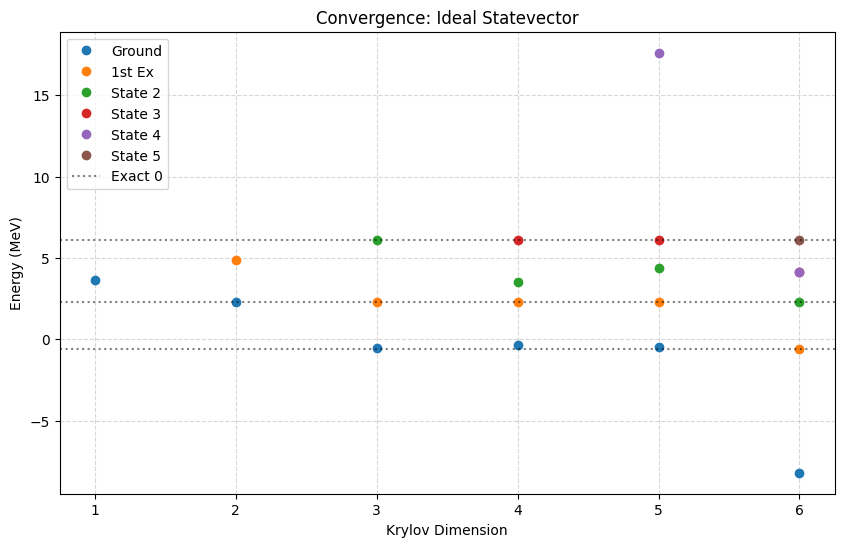


Running Noisy Simulation...

=== Running Quantum Krylov: Noisy (FakeManila) ===
  Dimension: 1
  [Gate Count Sample] Overlap Circuit (N_00):
[Re(N_00)] Depth: 197, Gates: OrderedDict({'rz': 103, 'cx': 96, 'sx': 51, 'x': 2, 'measure': 1})
    Energies: [14.3228014]
  Dimension: 2
  [Gate Count Sample] Overlap Circuit (N_00):
[Re(N_00)] Depth: 195, Gates: OrderedDict({'rz': 99, 'cx': 98, 'sx': 47, 'x': 2, 'measure': 1})
  [Gate Count Sample] Off-Diagonal Circuit (H_10):
[Re(H_10)] Depth: 2308, Gates: OrderedDict({'rz': 1467, 'sx': 1175, 'cx': 624, 'x': 4, 'measure': 4, 'barrier': 1})
    Energies: [13.91360252 16.53183993]
  Dimension: 3
  [Gate Count Sample] Overlap Circuit (N_00):
[Re(N_00)] Depth: 197, Gates: OrderedDict({'rz': 107, 'cx': 94, 'sx': 50, 'x': 2, 'measure': 1})
  [Gate Count Sample] Off-Diagonal Circuit (H_10):
[Re(H_10)] Depth: 2124, Gates: OrderedDict({'rz': 1428, 'sx': 1229, 'cx': 618, 'x': 12, 'measure': 4, 'barrier': 1})
    Energies: [15.19098266 17.39799936 20.70

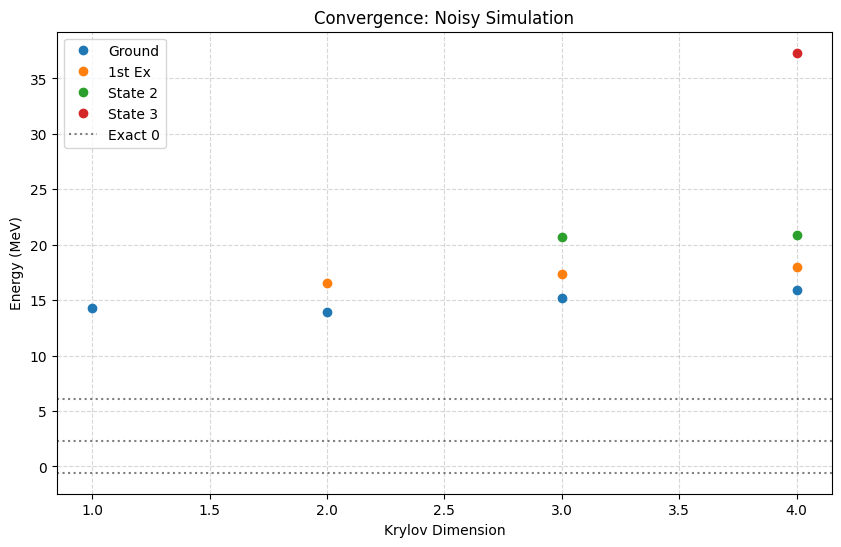


Real Device Execution skipped (RUN_REAL_DEVICE = False).


In [5]:

# --- General Execution Function ---

def run_qkrylov_loop(sampler, mode_name, max_iter=3, delta_t=1.0, shots=2048, regularization=0.0, backend_for_transpile=None):
    print(f"\n=== Running Quantum Krylov: {mode_name} ===")
    
    using_sv = isinstance(sampler, StatevectorSampler)
        
    # Loop
    qkrylov_energies = [] 
    iter_list = range(1, max_iter + 1)
    
    for it in iter_list:
        print(f"  Dimension: {it}")
        
        # Compute N and H matrices
        Nmat = compute_N_matrix(it, delta_t, 10, 3, [np.pi/4]*2, H_op, shots, sampler, 
                               ancilla_qubits=[0], target_qubits=[1,2,3], using_statevector=using_sv,
                               backend_for_transpile=backend_for_transpile)
                               
        Hmat = compute_H_matrix(it, delta_t, 10, 3, [np.pi/4]*2, H_op, {0:"IZ", 1:"XX", 2:"YY"}, shots, sampler,
                               ancilla_qubits=[0], target_qubits=[1,2,3], using_statevector=using_sv,
                               backend_for_transpile=backend_for_transpile)

        # Regularization for Rank Deficiency
        if regularization > 0:
            Nmat += regularization * np.eye(it)

        # Solve Generalized Eigenvalue Problem
        try:
            eigvals, eigvecs = linalg.eig(Hmat, Nmat)
            eigvals = np.sort(np.real(eigvals))
        except linalg.LinAlgError:
            print("    LinAlgError: Singular matrix. Trying higher regularization...")
            Nmat += 1e-2 * np.eye(it) 
            eigvals, eigvecs = linalg.eig(Hmat, Nmat)
            eigvals = np.sort(np.real(eigvals))
            
        qkrylov_energies.append(eigvals)
        print(f"    Energies: {eigvals}")

    return iter_list, qkrylov_energies

def plot_results(iter_list, energies, title, exact_evals):
    plt.figure(figsize=(10, 6))
    max_k = len(iter_list)
    for level in range(max_k):
        x_vals = []
        y_vals = []
        for i, val in enumerate(iter_list):
             if level < len(energies[i]):
                 x_vals.append(val)
                 y_vals.append(energies[i][level])
        if x_vals:
             label_t = f'State {level}'
             if level==0: label_t='Ground'
             elif level==1: label_t='1st Ex'
             plt.plot(x_vals, y_vals, 'o', label=label_t)
             
    for i, e in enumerate(exact_evals):
        if i < 4:
            plt.axhline(y=e, linestyle=':', color='k', alpha=0.5, label=f'Exact {i}' if i<1 else "")
            
    plt.xlabel('Krylov Dimension')
    plt.ylabel('Energy (MeV)')
    plt.title(title)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

# --- 1. Ideal Statevector Simulation ---
sampler_sv = StatevectorSampler()
iters_sv, energies_sv = run_qkrylov_loop(sampler_sv, 'Statevector', max_iter=6, delta_t=1.0)
plot_results(iters_sv, energies_sv, 'Convergence: Ideal Statevector', exact_evals)

# --- 2. Noisy Simulation (FakeManila) ---
print("\nRunning Noisy Simulation...")
fake_backend = FakeManilaV2()
aer_backend = AerSimulator.from_backend(fake_backend)
# Use BackendSamplerV2 which wraps a backend into SamplerV2 interface
sampler_noisy = BackendSamplerV2(backend=aer_backend)

# Pass aer_backend as backend_for_transpile to ensure gates are supported
iters_noisy, energies_noisy = run_qkrylov_loop(sampler_noisy, 'Noisy (FakeManila)', max_iter=4, delta_t=1.0, 
                                              shots=4096, regularization=1e-3, backend_for_transpile=aer_backend)
plot_results(iters_noisy, energies_noisy, 'Convergence: Noisy Simulation', exact_evals)

# --- 3. Real Device Execution (Optional) ---
# To enable, set RUN_REAL_DEVICE = True and ensure credentials are loaded
RUN_REAL_DEVICE = False

if RUN_REAL_DEVICE:
    try:
        service = QiskitRuntimeService()
        backend_real = service.least_busy(operational=True, simulator=False)
        print(f"\nRunning on Real Device: {backend_real.name}")
        
        with Session(service=service, backend=backend_real) as session:
            sampler_real = RuntimeSamplerV2(mode=session)
            iters_real, energies_real = run_qkrylov_loop(sampler_real, f'Real Device ({backend_real.name})', 
                                                        max_iter=4, delta_t=1.0, shots=4096, regularization=2e-2,
                                                        backend_for_transpile=backend_real)
            plot_results(iters_real, energies_real, f'Convergence: Real Device ({backend_real.name})', exact_evals)
    except Exception as e:
        print(f"Skipping Real Device Execution: {e}")
else:
    print("\nReal Device Execution skipped (RUN_REAL_DEVICE = False).")
